<a href="https://colab.research.google.com/github/donajac/AI_in_healthcare/blob/main/MRI_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving util.py to util.py


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/mri/images.zip"

Archive:  /content/gdrive/MyDrive/mri/images.zip
  inflating: images/BRATS_003.nii.gz  
  inflating: images/BRATS_002.nii.gz  
  inflating: images/BRATS_001.nii.gz  


In [ ]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
import tensorflow as tf
import util

In [ ]:
HOME_DIR = "/content/"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())

    return image, label

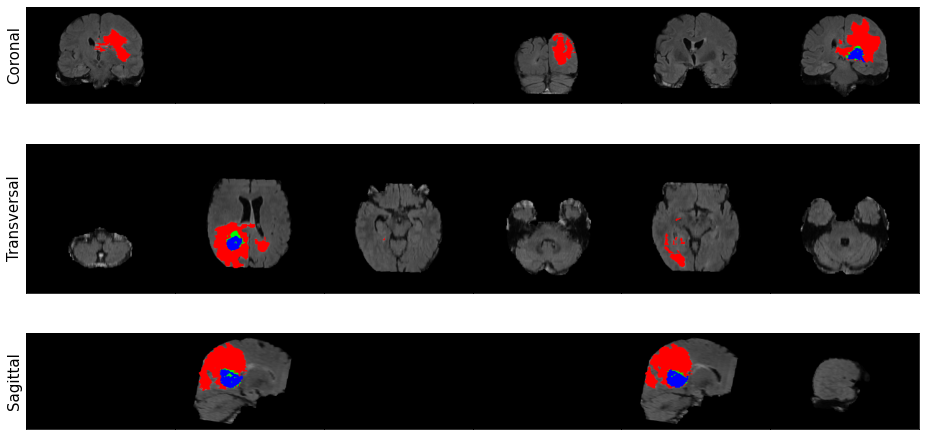

In [ ]:
image, label = load_case("/content/images/BRATS_003.nii.gz","/content/labels/BRATS_003.nii.gz")
image = util.get_labeled_image(image, label)

util.plot_image_grid(image)

In [ ]:
def get_sub_volume(image, label,
                   orig_x = 240, orig_y = 240, orig_z = 155,
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000,
                   background_threshold=0.95):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image,
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label.
            labels coded using discrete values rather than
            a separate dimension,
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension
            (num_classes, output_x, output_y, output_z)
    """
    # Initialize features and labels with `None`
    X = None
    y = None

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    tries = 0

    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(orig_x - output_x + 1 )
        start_y = np.random.randint(orig_y - output_y + 1 )
        start_z = np.random.randint(orig_z - output_z + 1 )

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]

        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes)

        # compute the background ratio
        bgrd_ratio = y[:,:,:, 0].sum() / (output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])

            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X, -1, 0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, -1, 0)

            ### END CODE HERE ###

            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]

            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

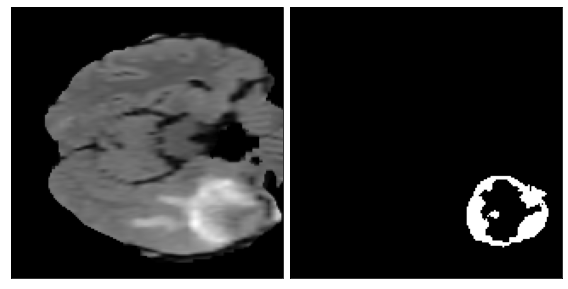

In [ ]:
image, label = load_case(DATA_DIR + "images/BRATS_001.nii.gz", DATA_DIR + "labels/BRATS_001.nii.gz")
X, y = get_sub_volume(image, label)
# enhancing tumor is channel 2 in the class label
# you can change indexer for y to look at different classes
util.visualize_patch(X[0, :, :, :], y[2])

In [ ]:
def standardize(image):
    """
    Standardize mean and standard deviation
        of each channel and z_dimension.

    Args:
        image (np.array): input image,
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # initialize to array of zeros, with same shape as the image
    standardized_image = np.empty(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - image_slice.mean()

            if image_slice.std() != 0:
                centered_scaled = image_slice / image_slice.std()
            else:
                centered_scaled = centered


            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled

    ### END CODE HERE ###

    return standardized_image

In [ ]:
X_norm = standardize(X)
print("standard deviation for a slice should be 1.0")
print(f"stddv for X_norm[0, :, :, 0]: {X_norm[0,:,:,0].std():.2f}")

standard deviation for a slice should be 1.0
stddv for X_norm[0, :, :, 0]: 1.00


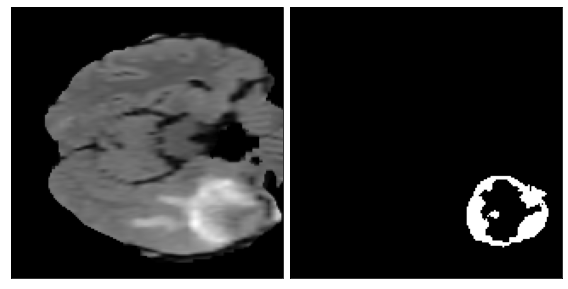

In [ ]:
util.visualize_patch(X_norm[0, :, :, :], y[2])

In [ ]:
def single_class_dice_coefficient(y_true, y_pred, axis=(0, 1, 2),
                                  epsilon=0.00001):
    """
    Compute dice coefficient for single class.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for single class.
                                    shape: (x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for single class.
                                    shape: (x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    dice_numerator = K.sum(2 * y_true * y_pred, axis= axis) + epsilon
    dice_denominator = K.sum(y_true,axis= axis) + K.sum(y_pred, axis = axis) + epsilon
    dice_coefficient = dice_numerator / dice_denominator
    return dice_coefficient

In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3),
                     epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    dice_numerator = K.sum(2 * y_true * y_pred, axis= axis) + epsilon
    dice_denominator = K.sum(y_true,axis= axis) + K.sum(y_pred, axis = axis) + epsilon
    dice_coefficient = K.mean(dice_numerator / dice_denominator,axis = 0)

    ### END CODE HERE ###

    return dice_coefficient

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3),
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    dice_numerator = 2 * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(K.square(y_true), axis = axis) + K.sum(K.square(y_pred), axis = axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator, axis = 0)

    ### END CODE HERE ###

    return dice_loss

In [ ]:
model = util.unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

In [ ]:
base_dir = HOME_DIR + "processed/"

with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)

# Get generators for training and validation sets
train_generator = util.VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=3, dim=(160, 160, 16), verbose=0)
valid_generator = util.VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=3, dim=(160, 160, 16), verbose=0)

steps_per_epoch = 10
n_epochs=5
validation_steps = 10

model.fit_generator(generator=train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        use_multiprocessing=True,
        validation_data=valid_generator,
        validation_steps=validation_steps)


In [ ]:
val_loss, val_dice = model.evaluate_generator(valid_generator)

print(f"validation soft dice loss: {val_loss:.4f}")
print(f"validation dice coefficient: {val_dice:.4f}")

Instructions for updating:
Please use Model.evaluate, which supports generators.
validation soft dice loss: 0.8827
validation dice coefficient: 0.1044


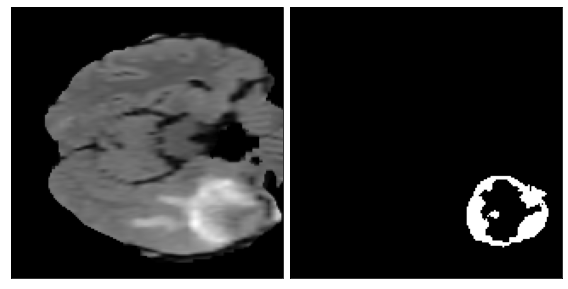

In [ ]:
util.visualize_patch(X_norm[0, :, :, :], y[2])

In [ ]:
X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
patch_pred = model.predict(X_norm_with_batch_dimension)

In [ ]:
patch_pred

In [ ]:
# set threshold.
threshold = 0.48

# use threshold to get hard predictions
patch_pred[patch_pred > threshold] = 1.0
patch_pred[patch_pred <= threshold] = 0.0

In [ ]:
patch_pred

Patch and ground truth


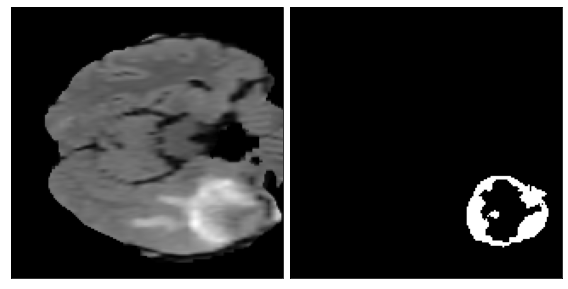

In [ ]:
print("Patch and ground truth")
util.visualize_patch(X_norm[0, :, :, :], y[2])
plt.show()

In [ ]:
patch_pred[0,2,:, :, :]

Patch and pred


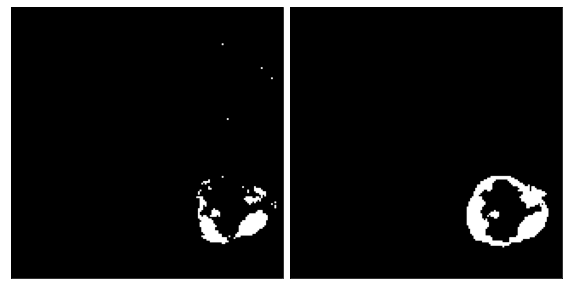

In [ ]:
print("Patch and pred")
util.visualize_patch(patch_pred[0,2,:, :, :], y[2])
plt.show()

Patch and prediction


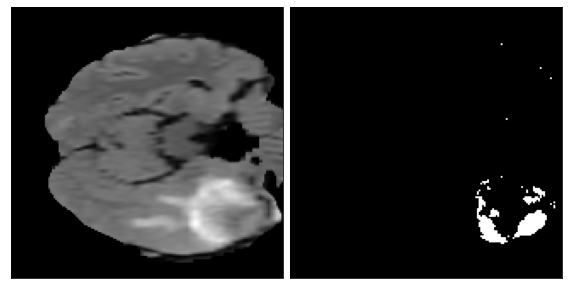

In [ ]:
print("Patch and prediction")
util.visualize_patch(X_norm[0, :, :, :], patch_pred[0,2,:, :, :])
plt.show()

In [ ]:
def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.

    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.

    Returns:
        sensitivity (float): precision for given class_num.
        specificity (float): recall for given class_num
    """

    # extract sub-array for specified class
    class_pred = pred[class_num]
    class_label = label[class_num]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute:

    # true positives
    tp = np.sum((class_label == 1) & (class_pred == 1))

    # true negatives
    tn = np.sum((class_label == 0) & (class_pred == 0))

    #false positives
    fp = np.sum((class_label == 0) & (class_pred == 1))

    # false negatives
    fn = np.sum((class_label == 1) & (class_pred == 0))

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    ### END CODE HERE ###

    return sensitivity, specificity

In [ ]:
from IPython.display import display
print("Test Case #3")

df = pd.DataFrame({'y_test': [1,1,0,0,0,0,0,0,0,1,1,1,1,1],
                   'preds_test': [1,1,0,0,0,1,1,1,1,0,0,0,0,0],
                   'category': ['TP','TP','TN','TN','TN','FP','FP','FP','FP','FN','FN','FN','FN','FN']
                  })

display(df)
pred = np.array( [df['preds_test']])
label = np.array( [df['y_test']])

sensitivity, specificity = compute_class_sens_spec(pred, label, 0)
print(f"sensitivity: {sensitivity:.4f}")
print(f"specificity: {specificity:.4f}")

Test Case #3


,y_test,preds_test,category
0,1,1,TP
1,1,1,TP
2,0,0,TN
3,0,0,TN
4,0,0,TN
5,0,1,FP
6,0,1,FP
7,0,1,FP
8,0,1,FP
9,1,0,FN


sensitivity: 0.2857
specificity: 0.4286


In [ ]:
sensitivity, specificity = compute_class_sens_spec(patch_pred[0], y, 2)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Sensitivity: 0.5865
Specificity: 0.9781


In [ ]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema',
                   'Non-Enhancing Tumor',
                   'Enhancing Tumor'],
        index = ['Sensitivity',
                 'Specificity'])

    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [ ]:
df = get_sens_spec_df(patch_pred[0], y)

print(df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity       0              0.8201          0.5865
Specificity  0.9994              0.9633          0.9781


In [ ]:
import sys
sys.getsizeof(image) / 1000  / 1000

285.69614399999995

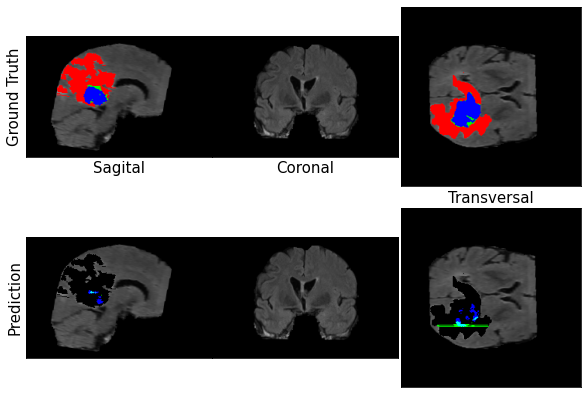

In [ ]:
image, label = load_case(DATA_DIR + "images/BRATS_003.nii.gz", DATA_DIR + "labels/BRATS_003.nii.gz")
pred = util.predict_and_viz(image, label, model, .5, loc=(130, 130, 77))

In [ ]:
whole_scan_label = keras.utils.to_categorical(label, num_classes = 4)
whole_scan_pred = pred

# move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]

In [ ]:
whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)

            Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity     0               0.217          0.4392
Specificity     1              0.9978          0.9993
